In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import time

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import pytorch_lightning as pl

import sklearn
import functools
import operator

import sys

import optuna

sys.path.insert(1,"/home/sbulusu/qcd_ml/neural_networks/libs/")

import lat_dataset_load_new_lightning
#import struct_torch_net_class_lightning
import custom_torch_net_class_lightning

import utils

from tqdm.notebook import tqdm

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Utilizing CUDA")
else:
    device = torch.device("cpu")
    print("Utilizing CPU")

Utilizing CUDA


In [5]:
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [6]:
checkpoint_path = "mlpconv1_2x2_64chan_midlat_nolin_ascircpadding_trial43/pl_checkpoints/CustomNet-043-epoch=199-val_loss=2.71943E-07.ckpt"

In [146]:
checkpoint_path = "pl_checkpoints/CustomNet-010-epoch=199-val_loss=3.08887E-07.ckpt"

In [147]:
#best_model = custom_torch_net_class_lightning.CustomNet.load_from_checkpoint(checkpoint_path,hyper_parameters)
model = custom_torch_net_class_lightning.CustomNet.load_from_checkpoint(checkpoint_path)

model.to(device)

model.configure_loss()

model.eval()

custom layer operation not defined, assuming previous layer_size for
<class 'torch.nn.modules.activation.ReLU'>
custom layer operation not defined, assuming previous layer_size for
<class 'torch.nn.modules.activation.ReLU'>
custom layer operation not defined, assuming previous layer_size for
<class 'misc_modules.Mean'>


CustomNet(
  (cnn): Net(
    (layers): ModuleList(
      (0): AsymmetricCircularPadding()
      (1): Conv2d(4, 64, kernel_size=[2, 2], stride=[1, 1])
      (2): ReLU()
      (3): AsymmetricCircularPadding()
      (4): Conv2d(64, 64, kernel_size=[2, 2], stride=[1, 1])
      (5): ReLU()
      (6): AdaptiveAvgPool2d(output_size=[1, 1])
    )
  )
  (dense1): Net(
    (layers): ModuleList(
      (0): Reshape()
      (1): Mean()
    )
  )
  (loss): MSELoss()
)

In [148]:
#conv = best_model.cnn.layers[1]
#conv.weight

In [149]:
#mlpconv = best_model.cnn.layers[4]
#mlpconv.weight

In [170]:
#[phi2, n]
test_lat_size = [2,2]
#test_lat_size = [5,5]

#kl_conf = torch.ones([1,2,2,3,3]).to("cuda:0")
kl_conf = torch.zeros(1,2,2,*test_lat_size).to("cuda:0")
#kl_conf[:,1,0,:,:] = 0
kl_conf[:,0,0,:,:] = 0
input_conf = kl_conf.reshape(1,4,*test_lat_size)
model(input_conf)

tensor([[0.2088, 0.0000]], device='cuda:0', grad_fn=<MeanBackward1>)

In [171]:
"""calculate f"""
def link_per_lat_point(links, lat_size, dims):

    #empty channels where the linsk on other directions should be saved
    #empty_link_channels = np.zeros(links.shape)
    #empty_link_channels = torch.zeros(*links.shape, dtype=int)
    empty_link_channels = links.clone()
    for d in range(dims):
        #print(d)
        #print(links)
        d_links = links[d]
        #print(d_links)
        #perm_links = np.roll(d_links, shift=1, axis=d)
        perm_links = torch.roll(d_links, shifts=1, dims=d)
        #print(perm_links)
        
        #print(d_slices)
        #empty_link_channels[d] = links[zip(d_slices)]
        empty_link_channels[d] = perm_links
        
    #not supported
    #empty_link_channels = empty_link_channels[::-1]
    #torch.flip(input=empty_link_channels, dims=[0])
    
    #complete_links = np.concatenate((links,empty_link_channels), axis=0)
    complete_links = torch.cat((links,empty_link_channels), dim=0)
            
            
    return complete_links

def f_calc(k_links, l_links, lat_size, dims):
    full_k_links = link_per_lat_point(k_links, lat_size, dims)
    full_l_links = link_per_lat_point(l_links, lat_size, dims)
    #print(full_k_links.shape)
    #print(full_l_links.shape)
    
    #abs_full_k_links = np.abs(full_k_links)
    abs_full_k_links = torch.abs(full_k_links)
    
    #calc_f = (abs_full_k_links + 2*full_l_links).sum(axis=0).astype(int)
    calc_f = (abs_full_k_links + 2*full_l_links).sum(axis=0)

    #return calc_f.astype(int)
    return calc_f

In [391]:
W_obs_ratio = np.loadtxt("W_obs_ratio.txt")

k_max = 40
output_phis = torch.zeros(k_max)
output_ns = torch.zeros(k_max)

phis = torch.zeros(k_max)
ns = torch.zeros(k_max)


for i in tqdm(range(k_max)):
    
    #kl_conf = torch.ones([1,2,2,3,3]).to("cuda:0")
    #kl_conf = torch.zeros(1,2,2,*test_lat_size).to("cuda:0")
    kl_conf = torch.zeros(1,2,2,*test_lat_size)
    #kl_conf[:,1,0,:,:] = 0
    kl_conf[:,0,0,:,:] = i
    #kl_conf[:,0,1,:,:] = i
    input_conf = kl_conf.reshape(1,4,*test_lat_size)
    
    ns[i] = torch.mean(kl_conf[0,0,0])
    
    f = f_calc(kl_conf[0,0], kl_conf[0,1], test_lat_size, len(test_lat_size))
    np_f_flat = np.array(f.flatten(), dtype=int)
    np_f_flat2 = (np_f_flat/2).astype(int)
    #print(np_f_flat)
    #print(np_f_flat2)
    
    #print(np.all(np_f_flat % 2 == 0))
    
    #W_conf = torch.tensor(W_obs_ratio[np_f_flat])
    W_conf = torch.tensor(W_obs_ratio[np_f_flat2])
    phis[i] = torch.mean(W_conf)
    
    
    output = model(input_conf.to("cuda:0"))
    #print(output)
    output_phis[i] = float(output[0][0])
    output_ns[i] = float(output[0][1])

In [390]:
cont_k_stop = 40
delta = 0.01
cont_k_range = torch.arange(start=0, end=cont_k_stop, step=delta, dtype=float)
cont_output_phis = torch.zeros(cont_k_range.size())
cont_output_ns = torch.zeros(cont_k_range.size())
for k_val_i in tqdm(range(len(cont_k_range))):
    
    #kl_conf = torch.ones([1,2,2,3,3]).to("cuda:0")
    #kl_conf = torch.zeros(1,2,2,*test_lat_size).to("cuda:0")
    kl_conf = torch.zeros(1,2,2,*test_lat_size)
    #kl_conf[:,1,0,:,:] = 0
    kl_conf[:,0,0,:,:] = cont_k_range[k_val_i]
    #kl_conf[:,0,1,:,:] = i
    input_conf = kl_conf.reshape(1,4,*test_lat_size)
    
    #ns[i] = torch.mean(kl_conf[0,0,0])
    
    #f = f_calc(kl_conf[0,0], kl_conf[0,1], test_lat_size, len(test_lat_size))
    #np_f_flat = np.array(f.flatten(), dtype=int)
    #np_f_flat2 = (np_f_flat/2).astype(int)
    #print(np_f_flat)
    #print(np_f_flat2)
    
    #print(np.all(np_f_flat % 2 == 0))
    
    #W_conf = torch.tensor(W_obs_ratio[np_f_flat])
    #W_conf = torch.tensor(W_obs_ratio[np_f_flat2])
    #phis[i] = torch.mean(W_conf)
    
    
    output = model(input_conf.to("cuda:0"))
    #print(output)
    cont_output_phis[k_val_i] = float(output[0][0])
    cont_output_ns[k_val_i] = float(output[0][1])

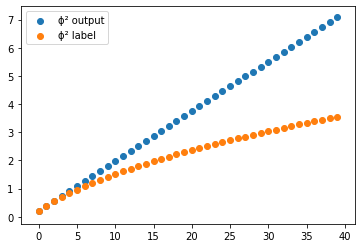

In [393]:
"""linearly rising kt"""
plt.scatter(range(len(output_phis)), output_phis, label="ϕ² output")
plt.scatter(range(len(phis)), phis, label="ϕ² label")
plt.legend(loc="upper left")

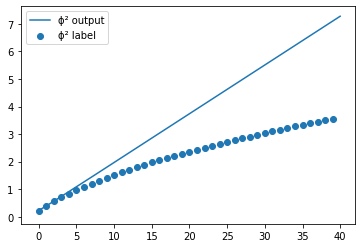

In [397]:
"""linearly rising kt"""
#plt.scatter(range(len(output_phis)), output_phis, label="ϕ² output")
plt.plot(cont_k_range, cont_output_phis, label="ϕ² output")
plt.scatter(range(len(phis)), phis, label="ϕ² label")
plt.legend(loc="upper left")

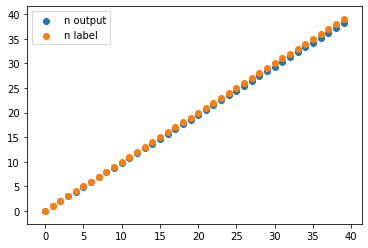

In [261]:
"""linearly rising kt"""
plt.scatter(range(len(output_ns)), output_ns, label="n output")
plt.scatter(range(len(ns)), ns, label="n label")
plt.legend(loc="upper left")

In [262]:
W_obs_ratio = np.loadtxt("W_obs_ratio.txt")

k_max = 20
output_phis = torch.zeros(k_max)
output_ns = torch.zeros(k_max)

phis = torch.zeros(k_max)
ns = torch.zeros(k_max)


for i in tqdm(range(k_max)):
    
    #kl_conf = torch.ones([1,2,2,3,3]).to("cuda:0")
    #kl_conf = torch.zeros(1,2,2,*test_lat_size).to("cuda:0")
    kl_conf = torch.zeros(1,2,2,*test_lat_size)
    #kl_conf[:,1,0,:,:] = 0
    kl_conf[:,0,:,:,:] = i
    input_conf = kl_conf.reshape(1,4,*test_lat_size)
    
    ns[i] = torch.mean(kl_conf[0,0,0])
    
    f = f_calc(kl_conf[0,0], kl_conf[0,1], test_lat_size, len(test_lat_size))
    np_f_flat = np.array(f.flatten(), dtype=int)
    np_f_flat2 = (np_f_flat/2).astype(int)
    #print(np_f_flat)
    #print(np_f_flat2)
    
    #print(np.all(np_f_flat % 2 == 0))
    
    #W_conf = torch.tensor(W_obs_ratio[np_f_flat])
    W_conf = torch.tensor(W_obs_ratio[np_f_flat2])
    #print(np.all(np_f_flat % 2 == 0))
    
    phis[i] = torch.mean(W_conf)
    
    
    output = model(input_conf.to("cuda:0"))
    #print(output)
    output_phis[i] = float(output[0][0])
    output_ns[i] = float(output[0][1])

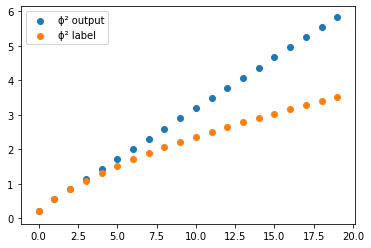

In [263]:
"""linearly rising k links"""
plt.scatter(range(len(output_phis)), output_phis, label="ϕ² output")
plt.scatter(range(len(phis)), phis, label="ϕ² label")
plt.legend(loc="upper left")

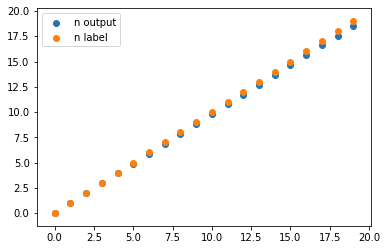

In [264]:
"""linearly rising k links"""
plt.scatter(range(len(output_ns)), output_ns, label="n output")
plt.scatter(range(len(ns)), ns, label="n label")
plt.legend(loc="upper left")

In [267]:
W_obs_ratio = np.loadtxt("W_obs_ratio.txt")

k_max = 9
output_phis = torch.zeros(k_max)
output_ns = torch.zeros(k_max)

phis = torch.zeros(k_max)
ns = torch.zeros(k_max)

size = tuple(np.concatenate(([1,2,2], test_lat_size)))


for i in tqdm(range(k_max)):
    
    #kl_conf = torch.ones([1,2,2,3,3]).to("cuda:0")
    #kl_conf = torch.zeros(1,2,2,*test_lat_size).to("cuda:0")
    kl_conf = torch.zeros(1,2,2,*test_lat_size)
    kl_conf = torch.full(size, fill_value=i)
    #kl_conf[:,1,0,:,:] = 0
    #kl_conf[:,0,0,:,:] = i
    input_conf = kl_conf.reshape(1,4,*test_lat_size)
    
    ns[i] = torch.mean(kl_conf[0,0,0])
    
    f = f_calc(kl_conf[0,0], kl_conf[0,1], test_lat_size, len(test_lat_size))
    np_f_flat = np.array(f.flatten(), dtype=int)
    np_f_flat2 = (np_f_flat/2).astype(int)
    #print(np_f_flat)
    #print(np_f_flat2)
    
    #print(np.all(np_f_flat % 2 == 0))
    
    #W_conf = torch.tensor(W_obs_ratio[np_f_flat])
    W_conf = torch.tensor(W_obs_ratio[np_f_flat2])

    phis[i] = torch.mean(W_conf)
    
    
    output = model(input_conf.to("cuda:0"))
    #print(output)
    output_phis[i] = float(output[0][0])
    output_ns[i] = float(output[0][1])

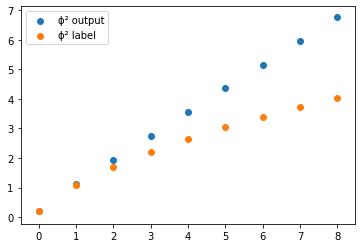

In [268]:
"""linearly rising links"""
plt.scatter(range(len(output_phis)), output_phis, label="ϕ² output")
plt.scatter(range(len(phis)), phis, label="ϕ² label")
plt.legend(loc="upper left")

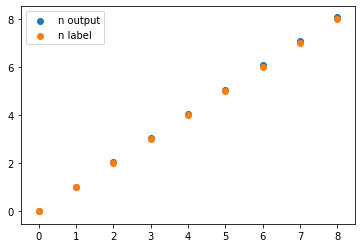

In [269]:
"""linearly rising links"""
plt.scatter(range(len(output_ns)), output_ns, label="n output")
plt.scatter(range(len(ns)), ns, label="n label")
plt.legend(loc="upper left")

In [181]:
lat_size = [2,2]
conf_size = np.concatenate(([2],lat_size))
links = torch.arange(0,2*np.prod(lat_size), dtype=int).reshape(*conf_size)
#print(links)
print(links.shape)
new_links = link_per_lat_point(links, lat_size, len(lat_size))
print(new_links.shape)

torch.Size([2, 2, 2])
torch.Size([4, 2, 2])


In [182]:
print(new_links)

tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]],

        [[2, 3],
         [0, 1]],

        [[5, 4],
         [7, 6]]])


In [183]:
print(new_links[0,:,:])

tensor([[0, 1],
        [2, 3]])


In [164]:
print(new_links[0,:,:])

tensor([[0, 1],
        [2, 3]])


In [377]:
lat_size = [2,2]
#lat_size = [5,5]
#lat_size = [10,10]
dims = len(lat_size)
link_max = 10
conf_size = np.concatenate(([2],lat_size))
num_conf = 10000
#num_conf = 100
random_size = tuple(np.concatenate(([num_conf], conf_size)))

k_links = torch.randint(low=-link_max, high=link_max+1, size=random_size)
l_links = torch.randint(low=0, high=link_max, size=random_size)


f = torch.zeros(num_conf, *lat_size, dtype=int)
phi2_labels = torch.zeros(num_conf)
n_labels = torch.zeros(num_conf)

physical_conf_indices = []

for conf_i in tqdm(range(num_conf)):
    #print(k_links[conf_i].size())
    #print(l_links[conf_i].size())
    #print("\n")
    f[conf_i] = f_calc(k_links[conf_i], l_links[conf_i], lat_size, dims)
    
    np_f_flat = np.array(f[conf_i].flatten(), dtype=int)
    np_f_flat2 = (np_f_flat/2).astype(int)
    #print(np_f_flat)
    #print(np_f_flat2)
    
    #print(np.all(np_f_flat % 2 == 0))
    
    if np.all(np_f_flat % 2 == 0):
        physical_conf_indices.append(conf_i)
    
    W_conf = torch.tensor(W_obs_ratio[np_f_flat2])
    #W_conf = torch.tensor(W_obs_ratio[np_f_flat])
    #W_conf = torch.tensor(W_obs_ratio[f[conf_i].flatten()], dtype=float)
    
    phi2_labels[conf_i] = torch.mean(W_conf)
    n_labels[conf_i] = torch.mean(k_links[conf_i][0].float())
    

    
#labels = np.stack((phi2_labels,n_labels), axis=1)
labels = torch.zeros(num_conf,2)
labels[:,0] = phi2_labels
labels[:,1] = n_labels

print(labels.size())


torch.Size([10000, 2])


In [378]:
len(physical_conf_indices)

1244

In [379]:
confs = torch.cat((k_links, l_links), dim=1)
#torch_confs = torch.tensor(confs, device="cuda:0")
torch_confs = confs.to("cuda:0")

In [380]:
outputs = model(torch_confs.float()).detach().cpu().numpy()
#print(outputs)
#print(phi2_labels)
#print(n_labels)
#print(labels)

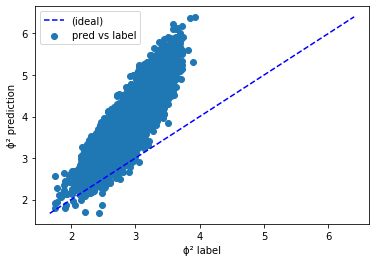

In [381]:
x_min = np.min(outputs[:,0])
x_max = np.max(outputs[:,0])

plt.scatter(labels[:,0], outputs[:,0], label="pred vs label")
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")
plt.ylabel("ϕ² prediction")
plt.xlabel("ϕ² label")
plt.legend()

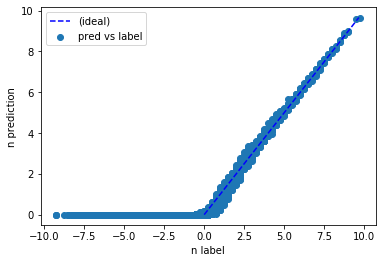

In [382]:
x_min = np.min(outputs[:,1])
x_max = np.max(outputs[:,1])

plt.scatter(labels[:,1], outputs[:,1], label="pred vs label")
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")
plt.ylabel("n prediction")
plt.xlabel("n label")
plt.legend()

In [383]:
physical_conf_indices = np.array(physical_conf_indices, dtype=int)
#print(physical_conf_indices)
#print(type(physical_conf_indices))

In [384]:
phi_labels = labels[:,0]
physical_phi_labels = phi_labels[physical_conf_indices]
#physical_phi_labels

phi_outputs = outputs[:,0]
physical_phi_outputs = phi_outputs[physical_conf_indices]
#print(physical_phi_outputs)

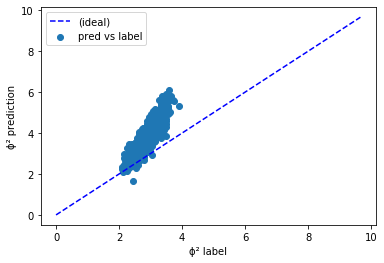

In [385]:
plt.scatter(physical_phi_labels, physical_phi_outputs, label="pred vs label")
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")
plt.ylabel("ϕ² prediction")
plt.xlabel("ϕ² label")
plt.legend()

In [386]:
n_labels = labels[:,1]
physical_n_labels = n_labels[physical_conf_indices]
#physical_phi_labels

n_outputs = outputs[:,1]
physical_n_outputs = n_outputs[physical_conf_indices]
#print(physical_phi_outputs)

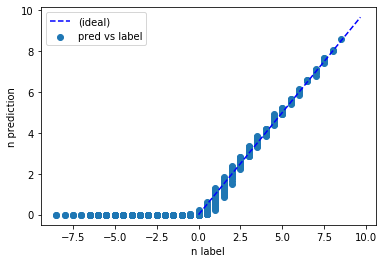

In [387]:
plt.scatter(physical_n_labels, physical_n_outputs, label="pred vs label")
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="b", label="(ideal)")
plt.ylabel("n prediction")
plt.xlabel("n label")
plt.legend()